In [1]:
import sys
sys.path.append('../src')
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.special import erfinv
from sparse_coding_model import SparseCoding
from utils import *
from train_funcs import load_models, generate_HVC
rng = np.random.default_rng()

In [2]:
fname = '../realistic_auditory_processing/learned_song_responses.npz'
T_SONG = np.load(fname)['ctrl'].shape[2] # (n_songs, N, T)

In [3]:
adult = np.load('../adult_songs/data.npz')
n_samples, n_syl, n_freq_bins, n_time_bins = adult['spec_syl'].shape
samples = []
for i in range(n_syl):
    for j in range(n_samples):
        samples.append(adult['spec_syl'][j,i].flatten())
samples = np.stack(samples, 0)

/home/zg93/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


6

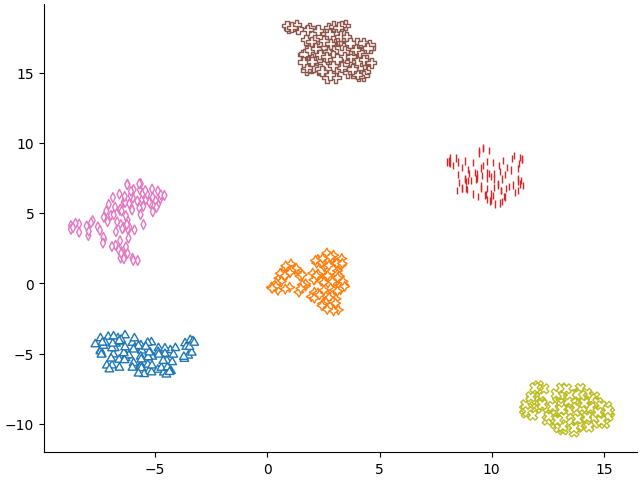

In [4]:
import umap
reducer = umap.UMAP(n_neighbors=5, min_dist=0.5)
embedding = reducer.fit_transform(samples)

from sklearn.cluster import HDBSCAN
clusterer = HDBSCAN(min_cluster_size=5)
labels = clusterer.fit_predict(embedding) + 1
unique_labels = np.unique(labels)

cmap = plt.get_cmap('tab10')
syl_colors = np.concat([np.tile(cmap(i/n_syl), (n_samples,1)) for i in range(n_syl)])
for i in unique_labels:
    mask = labels == i
    if i == 0:
        m = '.'
        print('Has outliers')
    elif i < 3:
        m = 'X' if i == 1 else 'P'
    else:
        m = (i-2,1,0) if i < 9 else (i-7, 0, 90)
    plt.scatter(embedding[mask,0], embedding[mask,1], s=50, marker=m, 
                fc='white', ec=syl_colors[mask])
len(unique_labels)

In [5]:
syl_idx_2_labels = [np.unique(labels[i*n_samples:(i+1)*n_samples]) for i in range(n_syl)]
syl_idx_2_labels

[array([5]), array([6]), array([3]), array([2]), array([4]), array([1])]

State at step $i$: $$s_i = \tau^{-1} \sum_{t'=0}^{\tau}\mathbf r^H(i\cdot\tau+t')$$

Action: 10-dimensional coefficients for 10 basis of spectrograms $$a_i \sim N(\pi(s_i), \sigma I)$$

Reward: $$v_i = -m\left(\tau^{-1} \sum_{s=0}^{\tau} \mathbf r^E(\mathbf r^H(i\cdot\tau+s), a_i)\right)$$

In [6]:
class Environment:
    VOCAL_ERR_NET_MAP = {'FF': 0, 'EI-HVC2E': 1, 'EI-E2E': 2, 'EI-E2I2E': 3}
    STATE_INTERVAL = 60 # approximated length of the shortest syllable
    
    def __init__(self, syl_samples, labels, n_time_bins, T_song, 
                 dir_sensory_net, dir_vocal_error_net, vocal_error_net_type, 
                 T_burn=500, T_post=200, spec_dt=10,
                 HVC_peak_rate=150, HVC_kernel_width=20):
        # Constants
        self.T_song = T_song
        self.T_burn = T_burn
        self.T_post = T_post
        self.T = T_burn + T_song + T_post
        self.spec_dt = spec_dt
        
        # Store action basis
        self.syl_samples = syl_samples
        self.labels = labels
        self.unique_labels = np.concat([[-1], np.unique(labels)]) # -1 silence
        self.action_dim = len(self.unique_labels)
        
        # Load sensory net
        sensory_basis = torch.load(dir_sensory_net)
        assert sensory_basis.shape[0] % n_time_bins == 0
        self.n_sensory_basis = sensory_basis.shape[1]
        self.n_time_bins = n_time_bins
        self.n_freq_bins = sensory_basis.shape[0] // n_time_bins
        self.sensory = SparseCoding(n_basis=self.n_sensory_basis, 
                                    n_freq_bins=self.n_freq_bins, 
                                    n_time_bins=self.n_time_bins)
        self.sensory.basis = sensory_basis

        # Load vocal error net
        ret = load_models(dir_vocal_error_net, 'neighbor', 'EIIE', 'mature_hvc', 0)
        self.ve_net = ret[Environment.VOCAL_ERR_NET_MAP[vocal_error_net_type]]
        self.sensory_mapping = ret[-1]
        self.ve_net_in_dim, self.HVC_dim = self.ve_net.W.shape
        
        # Construct states from HVC firing
        burst_ts = np.linspace(T_burn, T_burn+T_song, num=self.HVC_dim, endpoint=False)
        aux = np.zeros((self.HVC_dim,1))
        self.rH = generate_HVC(T_burn+T_song+T_post, burst_ts[:,None], 
                               HVC_peak_rate+aux, HVC_kernel_width+aux)

        # itvl = Environment.STATE_INTERVAL # for convenience
        # self.states = [torch.tensor(rH[t:t+itvl].mean(axis=0), dtype=torch.float32) 
        #                for t in range(T_burn, T_burn+T_song, itvl)]
        # self.states = torch.stack(self.states)
        # self.states = (self.states - self.states.mean()) / self.states.std()
        self.states = list(range(T_song//Environment.STATE_INTERVAL))
        self.state_dim = len(self.states)

        # Buffers
        self._cur_state = 0
        self._song_spec = np.zeros((self.n_freq_bins, (T_song+T_post)//self.spec_dt))
        self._song_emb = np.zeros((T_song+T_post, self.ve_net_in_dim))
    
    def _perform(self, action):
        # bos = (action.numpy() @ self.action_basis)
        # bos = bos.reshape(self.n_freq_bins, self.n_time_bins)
        lab = self.unique_labels[action.item()]
        if lab == -1: # silence
            bos = np.zeros((self.n_freq_bins, self.n_time_bins))
            emb = np.zeros(self.sensory_mapping.shape[-1])
        else:
            i = rng.choice(np.where(self.labels == lab)[0])
            bos = self.syl_samples[i].reshape(self.n_freq_bins, self.n_time_bins)
            emb = self.sensory(torch.tensor(bos, dtype=torch.float32), n_iter_coef=200)
            emb = np.squeeze(emb.numpy()) @ self.sensory_mapping
        return bos, emb

    def reset(self):
        self._cur_state = 0
        self._song_spec[:] = 0
        self._song_emb[:] = 0
        return 0
    
    def step(self, action, song_spec=False):
        if self._cur_state >= len(self.states): # already done
            return None, True

        bos, emb = self._perform(action)

        # Determine how many intervals to jump
        dur = (bos.sum(axis=0) != 0).sum() * self.spec_dt # the duration of non-zero part
        step_size = int(np.round(dur / Environment.STATE_INTERVAL))
        step_size = 1 if step_size == 0 else step_size # if 0, treated as silence

        # Add to song embedding
        t0 = self._cur_state * Environment.STATE_INTERVAL
        t1 = (self._cur_state + step_size) * Environment.STATE_INTERVAL
        self._song_emb[t0:t1] = emb[None,:]
        
        if song_spec: # Add to song spectrum
            p, q = t0 // self.spec_dt, t1 // self.spec_dt # index range for song_spec
            mid = bos.shape[1] // 2 - 1 + bos.shape[1] % 2
            i, j = mid - step_size * 3, mid + step_size * 3 # clip range for bos
            if j > bos.shape[1]: # make it full spec width
                i, j = 0, self.n_time_bins
                q = p + self.n_time_bins        
            if q >= self._song_spec.shape[1]: # clip j
                j -= q - self._song_spec.shape[1]
            self._song_spec[:,p:q] = bos[:,i:j]
        
        self._cur_state += step_size # Update current state idx

        if self._cur_state >= len(self.states):
            return None, True
        else:
            return self._cur_state, False

    def init_ve_net(self):
        self.hE0 = rng.normal(loc=-10, scale=0.5, size=self.ve_net.NE)
        if hasattr(self.ve_net, 'NI'):
            self.hI0 = rng.normal(loc=-1, scale=0.5, size=self.ve_net.NI)
        else:
            self.hI0 = -1

    def reward(self, h0s=None):
        aud = np.zeros((self.T, self.ve_net_in_dim))
        aud[self.T_burn:self.T_burn+self._song_emb.shape[0]] = self._song_emb
        self.init_ve_net()
        hE0, hI0 = self.hE0, self.hI0
        rE, rI, _, hE, hI = self.ve_net.sim(hE0, hI0=hI0, rH=self.rH, aud=aud, 
                                            save_W_ts=[], T=self.T, dt=1, 
                                            noise_strength=0, no_progress_bar=True)
        return -rE.mean(axis=1)

    def get_song_spec(self):
        return self._song_spec.copy()

In [7]:
from torch.distributions import Categorical
import torch.nn.functional as F
class ActorCritic(nn.Module):
    def __init__(self, N_states, N_out):
        super(ActorCritic, self).__init__()
        self.actor = [nn.Parameter(torch.ones(N_out, dtype=torch.float)) 
                      for i in range(N_states)]
        self.actor = nn.ParameterList(self.actor)
        self.critic = nn.Parameter(-2 * torch.ones(N_states, dtype=torch.float)) 

    def forward(self, state):
        prob = F.softmax(self.actor[state], dim=-1)
        val = self.critic[state]
        dist = Categorical(prob)
        action = dist.sample()
        return action, val, dist

In [8]:
# env = Environment(dl.components_, n_time_bins, 
env = Environment(samples, labels, n_time_bins, T_SONG,
                  '../realistic_auditory_processing/net_params.pkl', 
                  '../results/', 'EI-E2I2E')

In [9]:
adult = np.load('../adult_songs/data.npz')

In [10]:
agent = ActorCritic(env.state_dim, env.action_dim)

optimizer = torch.optim.Adam(agent.parameters(), lr=5e-2, weight_decay=0)

In [11]:
actor_losses, critic_losses, total_rewards = [], [], []
actions, songs = [], []
gamma = 0.8

for epoch in tqdm(range(1001)):
    rewards, log_probs, vals = [], [], []

    done = False
    state = env.reset() # 0
    states = [state]
    while not done:
        action, val, dist = agent(state)
        state, done = env.step(action, song_spec=epoch%10==0)

        log_probs.append(-dist.log_prob(action))
        vals.append(val)
        if not done:
            states.append(state)
            
    if epoch % 10 == 0:
        songs.append(env.get_song_spec())

    rE = env.reward()
    # baseline subtraction; the rE here also includes the burning period from 0 to T_burn
    rE -= rE[200:].mean()
    itvl = Environment.STATE_INTERVAL # for convenience
    rewards = [rE[env.T_burn+states[t]*itvl:env.T_burn+states[t+1]*itvl].mean() 
               for t in range(len(states)-1)]
    rewards.append(rE[env.T_burn+states[-1]*itvl:].mean())
    rewards = np.array(rewards) * 10 + 2
    total_rewards.append(np.mean(rewards))

    Gs, G = [], 0
    for r in rewards[::-1]:
        G = r + G * gamma
        Gs.insert(0, G)
    # Gs = (np.array(Gs) - np.mean(Gs)) / np.std(Gs)
    actor_loss, critic_loss = 0, 0
    for G, lp, v in zip(Gs, log_probs, vals):
        advantage = G - v
        actor_loss += lp * advantage.item()
        # critic_loss += F.smooth_l1_loss(v, torch.tensor([G]))
        critic_loss += advantage**2
    critic_loss *= 10 # make it learn faster

    # if epoch % 50 == 0:
    #     print(actor_loss.item(), critic_loss.item())
    actor_losses.append(actor_loss.item())
    critic_losses.append(critic_loss.item())
    
    optimizer.zero_grad()
    loss = actor_loss + critic_loss
    loss.backward()
    optimizer.step()

100%|███████████████████████████████████████| 1001/1001 [09:14<00:00,  1.81it/s]


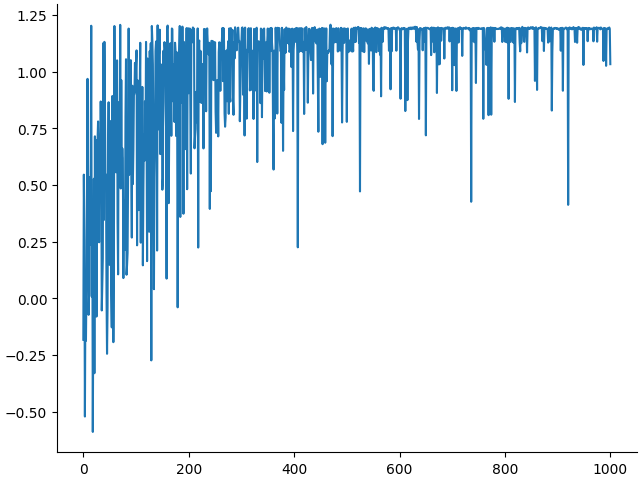

In [12]:
plt.plot(total_rewards)

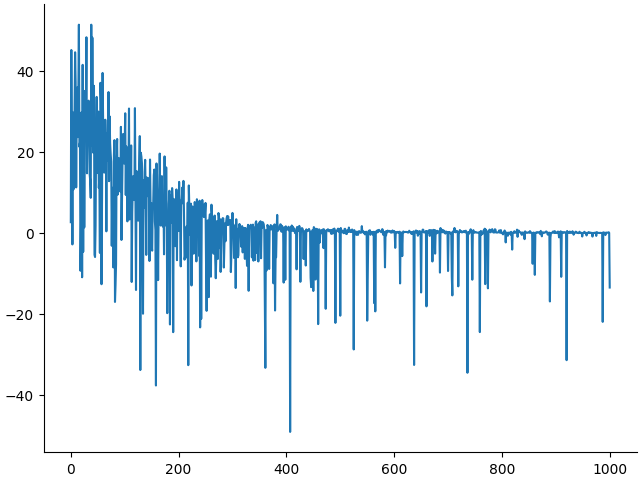

In [13]:
plt.plot(actor_losses)

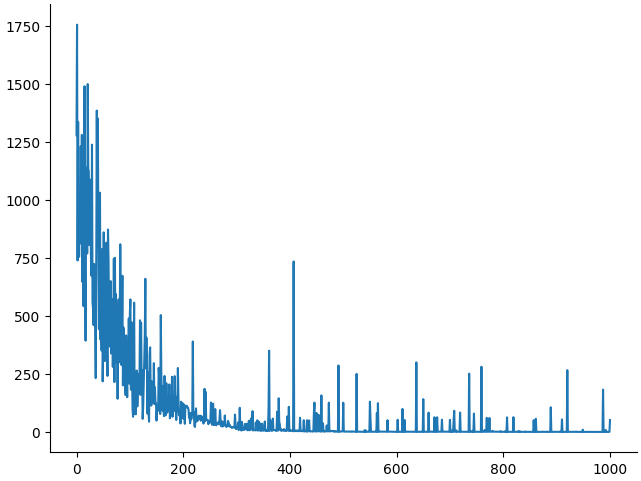

In [14]:
plt.plot(critic_losses)

(array([[ 2.,  5., 19., 27., 26., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  7., 17., 36., 28.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  3.,
         22., 30., 25.,  8.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 23.,
         48., 18.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4., 31., 43.,
         12.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0

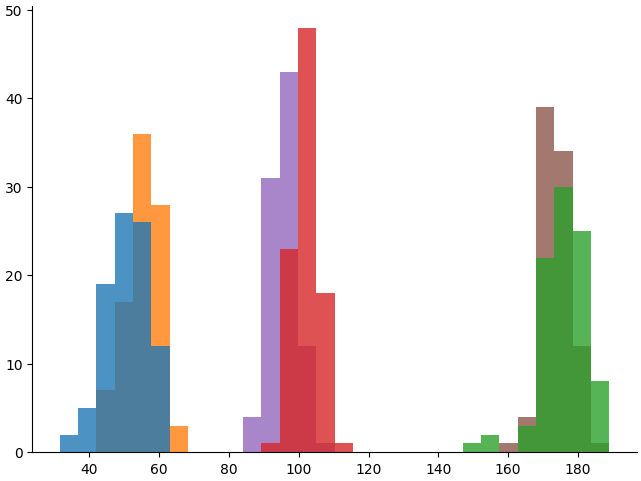

In [15]:
intervals = adult['syl_off'] - adult['syl_on']
plt.hist(intervals, histtype='stepfilled', alpha=0.8)

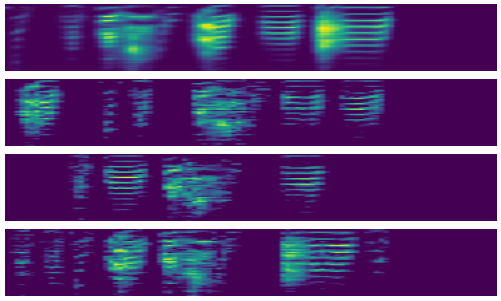

In [16]:
fig, ax = plt.subplots(4, figsize=(5, 3), sharex='all')
target = adult['spec_song'].mean(axis=0)
aux = np.zeros_like(songs[0])
aux[:,:target.shape[1]] = target
ax[0].imshow(aux)
ax[0].set_axis_off()
for i, j in enumerate((0, len(songs)//2, -1)):
    ax[i+1].imshow(songs[j])
    ax[i+1].set_axis_off()